In [197]:
# === Cell 1: 환경 설정 & Earth Engine 초기화 ===
import os, json, warnings
from pathlib import Path
from datetime import datetime, date, timedelta

import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

# 디렉터리
NB_DIR   = Path.cwd()
OUT_DIR  = NB_DIR / "outputs"
ASSETS   = OUT_DIR / "web_assets"
OUT_DIR.mkdir(exist_ok=True)
ASSETS.mkdir(parents=True, exist_ok=True)

# Earth Engine
EE_PROJECT_ID = os.environ.get("EE_PROJECT_ID", "nasa-flood")
EE_READY = False
try:
    import ee
    try:
        ee.Initialize(project=EE_PROJECT_ID)
        EE_READY = True
        print(f"✅ Earth Engine initialized (project='{EE_PROJECT_ID}')")
    except Exception:
        print("🔐 Authenticating with Earth Engine...")
        ee.Authenticate()
        ee.Initialize(project=EE_PROJECT_ID)
        EE_READY = True
        print(f"✅ Authenticated & initialized (project='{EE_PROJECT_ID}')")
except Exception as e:
    print("⚠️ earthengine-api not available. Will only load cached CSV/JSON.")
    EE_READY = False

print(f"⏰ Now: {datetime.now().isoformat(timespec='seconds')}")
print(f"📁 outputs: {OUT_DIR.resolve()}")
print(f"📁 web_assets: {ASSETS.resolve()}")


✅ Earth Engine initialized (project='nasa-flood')
⏰ Now: 2025-10-05T12:19:25
📁 outputs: C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs
📁 web_assets: C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets


In [198]:
# === Cell 2: 프로젝트 설정 & 유틸리티 함수 ===
# AOI/윈도/임계값/이벤트
if EE_READY:
    AOI_DELTA    = ee.Geometry.Rectangle([104.30,  8.50, 106.90, 10.90], geodesic=False)
    AOI_TONLESAP = ee.Geometry.Rectangle([103.30, 12.00, 105.20, 13.70], geodesic=False)

CFG = {
    "YEARS": list(range(2015, 2025)),
    "FLOOD_MONTHS": (8, 9),    # Aug–Sep
    "DROUGHT_MONTHS": (3, 4),  # Mar–Apr
    "TH_VV_DB": -16.0,
    "TH_VH_DB": -22.0,
    "BASELINE_YEARS": [2005, 2006, 2007, 2008],
    "EVENTS": {
        "JINGHONG_FLOW_CUT": "2019-07-15",
        "XIAOWAN_ONLINE":    "2009-01-01",
        "NUOZHADU_ONLINE":   "2012-01-01",
    },
}
FLOOD_M1, FLOOD_M2 = CFG["FLOOD_MONTHS"]
DRY_M1,   DRY_M2   = CFG["DROUGHT_MONTHS"]
EVENTS = {k: pd.to_datetime(v) for k, v in CFG["EVENTS"].items()}

# 공통 유틸
def _daterange_of_year_months(year:int, m1:int, m2:int):
    start = date(year, m1, 1)
    end   = (date(year+1,1,1) - timedelta(days=1)) if m2==12 else (date(year,m2+1,1)-timedelta(days=1))
    return start.isoformat(), end.isoformat()

if EE_READY:
    def s1_min(aoi, start, end, pol):
        return (ee.ImageCollection('COPERNICUS/S1_GRD')
                .filterBounds(aoi)
                .filterDate(start, end)
                .filter(ee.Filter.eq('instrumentMode','IW'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
                .select(pol).min().clip(aoi))

    def classify_water(img_min, pol, threshold_db):
        return img_min.lt(threshold_db).selfMask()

    def area_km2(mask_img, aoi, scale=30, band_name='constant'):
        area = (mask_img.multiply(ee.Image.pixelArea())
                .reduceRegion(ee.Reducer.sum(), aoi, scale, maxPixels=1e12))
        return ee.Number(area.get(band_name)).divide(1e6)

    def chirps_sum_mm(aoi, start, end):
        col = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
               .filterBounds(aoi).filterDate(start, end).select('precipitation'))
        # 빈 컬렉션 방어
        if col.size().getInfo() == 0:
            return None
        total = col.sum().reduceRegion(ee.Reducer.mean(), aoi, 5000, maxPixels=1e12)
        return ee.Number(total.get('precipitation'))

print("✅ Config ready | Years:", CFG["YEARS"][0], "-", CFG["YEARS"][-1])


✅ Config ready | Years: 2015 - 2024


In [199]:
# === Cell 3: 데이터 로딩 (Smart Cache System) ===
# 파일 우선, 없으면 EE로 계산 (가능할 때만). 모든 경로는 candidates 체계로 탐색.

# 경로 후보 생성기
PROJECT_ROOT = NB_DIR  # 노트북 루트 기준
CANDIDATE_DIRS = [
    ASSETS,                                  # 07 캐시
    OUT_DIR,                                 # notebooks/outputs
    PROJECT_ROOT / "outputs",                # 프로젝트 루트 outputs
    PROJECT_ROOT / "streamlit_app" / "data" / "processed",  # 앱 데이터
]

def _first_existing(*paths: Path):
    for p in paths:
        if p.exists():
            return p
    return None

def read_csv_candidates(*names):
    # names: 파일명 문자열들
    paths = [d / n for d in CANDIDATE_DIRS for n in names]
    for p in paths:
        if p.exists():
            print(f"[LOAD] CSV -> {p}")
            return pd.read_csv(p)
    print(f"[WARN] CSV not found in candidates: {[str(p) for p in paths][:3]} ...")
    return None

def read_json_candidates(*names):
    paths = [d / n for d in CANDIDATE_DIRS for n in names]
    for p in paths:
        if p.exists():
            print(f"[LOAD] JSON -> {p}")
            with open(p, "r", encoding="utf-8") as f:
                return json.load(f)
    print(f"[WARN] JSON not found in candidates: {[str(p) for p in paths][:3]} ...")
    return None

# EE 기반 빌더 (필요할 때만 호출)
def _build_annual_flood_df(aoi, years):
    rows=[]
    for y in years:
        start,end = _daterange_of_year_months(y, FLOOD_M1, FLOOD_M2)
        vv = s1_min(aoi, start, end, "VV")
        vh = s1_min(aoi, start, end, "VH")
        vv_mask = classify_water(vv, "VV", CFG["TH_VV_DB"])
        vh_mask = classify_water(vh, "VH", CFG["TH_VH_DB"])
        a_vv = float(area_km2(vv_mask, aoi, 30).getInfo() or 0.0)
        a_vh = float(area_km2(vh_mask, aoi, 30).getInfo() or 0.0)
        pr_n = chirps_sum_mm(aoi, start, end)
        pr   = float(pr_n.getInfo() or 0.0) if pr_n else 0.0
        rows.append({"year":y, "flood_vv_km2":a_vv, "flood_vh_km2":a_vh, "precip_wet_mm":pr})
    return pd.DataFrame(rows)

def _build_annual_dry_df(aoi, years):
    rows=[]
    for y in years:
        start,end = _daterange_of_year_months(y, DRY_M1, DRY_M2)
        vh = s1_min(aoi, start, end, "VH")
        vh_mask = classify_water(vh, "VH", CFG["TH_VH_DB"])
        a_vh = float(area_km2(vh_mask, aoi, 30).getInfo() or 0.0)
        pr_n = chirps_sum_mm(aoi, start, end)
        pr   = float(pr_n.getInfo() or 0.0) if pr_n else 0.0
        rows.append({"year":y, "dry_vh_km2":a_vh, "precip_dry_mm":pr})
    return pd.DataFrame(rows)

def smart_load_flood(aoi_name: str):
    # 이름 관례
    lower = aoi_name.lower()
    # 1) 캐시/기존 산출물
    df = read_csv_candidates(
        f"annual_flood_{lower}.csv",                     # 07 캐시
        f"flood_extent_{lower}_vv_vh_2015_2024.csv",     # 04 산출물 가정
        f"annual_analysis_{lower}.csv",                  # 02 산출물 가정
    )
    if df is not None:
        # 컬럼 표준화
        rename = {
            "vv_km2": "flood_vv_km2",
            "vh_km2": "flood_vh_km2",
            "precip_mm": "precip_wet_mm",
            "precipitation_mm": "precip_wet_mm",
        }
        df = df.rename(columns=rename)
        need = ["year","flood_vv_km2","flood_vh_km2","precip_wet_mm"]
        # AOI 열이 있으면 필터
        if "aoi" in df.columns:
            df = df[df["aoi"].str.lower().str.replace(" ","_")==lower]
        # 결측 열 보완
        for c in need:
            if c not in df.columns:
                df[c] = np.nan
        df = df[need].drop_duplicates(subset="year").sort_values("year")
        # 캐시로 저장
        (ASSETS / f"annual_flood_{lower}.csv").write_text(df.to_csv(index=False), encoding="utf-8")
        return df

    # 2) EE로 계산 (가능할 때만)
    if EE_READY:
        print(f"[BUILD] Computing flood (VV/VH) for {aoi_name} via GEE …")
        aoi = AOI_DELTA if aoi_name=="Mekong_Delta" else AOI_TONLESAP
        df = _build_annual_flood_df(aoi, CFG["YEARS"])
        df.to_csv(ASSETS / f"annual_flood_{lower}.csv", index=False)
        return df

    print(f"[ERROR] No flood dataset & EE not available → {aoi_name}")
    return pd.DataFrame(columns=["year","flood_vv_km2","flood_vh_km2","precip_wet_mm"])

def smart_load_dry(aoi_name: str):
    lower = aoi_name.lower()
    df = read_csv_candidates(
        f"annual_dry_{lower}.csv",                 # 07 캐시
        "dry_season_analysis_2015_2024.csv",       # 06 산출물
    )
    if df is not None:
        if "aoi" in df.columns:
            df = df[df["aoi"].str.lower().str.replace(" ","_")==lower].copy()
        rename = {
            "water_extent_km2": "dry_vh_km2",
            "precip_total_mm":  "precip_dry_mm",
        }
        df = df.rename(columns=rename)
        need = ["year","dry_vh_km2","precip_dry_mm"]
        for c in need:
            if c not in df.columns:
                df[c] = np.nan
        df = df[need].drop_duplicates(subset="year").sort_values("year")
        (ASSETS / f"annual_dry_{lower}.csv").write_text(df.to_csv(index=False), encoding="utf-8")
        return df

    if EE_READY:
        print(f"[BUILD] Computing dry-season (VH) for {aoi_name} via GEE …")
        aoi = AOI_DELTA if aoi_name=="Mekong_Delta" else AOI_TONLESAP
        df = _build_annual_dry_df(aoi, CFG["YEARS"])
        df.to_csv(ASSETS / f"annual_dry_{lower}.csv", index=False)
        return df

    print(f"[ERROR] No dry dataset & EE not available → {aoi_name}")
    return pd.DataFrame(columns=["year","dry_vh_km2","precip_dry_mm"])

# 실제 로드
print("="*80, "\n📊 LOADING (smart cache)\n", "="*80, sep="")
df_delta_flood = smart_load_flood("Mekong_Delta")
df_ts_flood    = smart_load_flood("Tonle_Sap")
df_delta_dry   = smart_load_dry("Mekong_Delta")
df_ts_dry      = smart_load_dry("Tonle_Sap")

# 머지 및 파생지표
df_delta = pd.merge(df_delta_flood, df_delta_dry, on="year", how="outer").sort_values("year")
df_ts    = pd.merge(df_ts_flood,    df_ts_dry,    on="year", how="outer").sort_values("year")
for df in (df_delta, df_ts):
    if {"flood_vh_km2","flood_vv_km2"}.issubset(df.columns):
        df["vh_gain_km2"] = df["flood_vh_km2"] - df["flood_vv_km2"]

print(f"Delta rows: {len(df_delta)} | Tonlé rows: {len(df_ts)}")
display(df_delta.head(3))
display(df_ts.head(3))


📊 LOADING (smart cache)
[LOAD] CSV -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\annual_flood_mekong_delta.csv
[LOAD] CSV -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\annual_flood_tonle_sap.csv
[LOAD] CSV -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\annual_dry_mekong_delta.csv
[LOAD] CSV -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\annual_dry_tonle_sap.csv
Delta rows: 10 | Tonlé rows: 10


,year,flood_vv_km2,flood_vh_km2,precip_wet_mm,dry_vh_km2,precip_dry_mm,vh_gain_km2
0,2015,33664.581621,39263.441131,482.863921,36829.428640,38.418497,5598.859510
1,2016,36979.498246,41105.051724,487.770975,40975.326203,11.114968,4125.553478
2,2017,46451.231475,48699.005287,448.641681,45017.500819,100.539218,2247.773812


,year,flood_vv_km2,flood_vh_km2,precip_wet_mm,dry_vh_km2,precip_dry_mm,vh_gain_km2
0,2015,3892.226791,4982.148934,470.792586,8801.694369,76.057223,1089.922143
1,2016,5898.124855,7430.943820,587.707040,14991.526078,48.135239,1532.818966
2,2017,8076.027192,10357.122467,547.240797,11562.232076,137.207115,2281.095275


In [200]:
# === Cell 4: Baseline 로딩 (Notebook 01 재사용) ===
def load_or_fallback_baselines():
    b = read_json_candidates("baseline_summary.json")
    if b and "areas" in b:
        base = {}
        for a in b["areas"]:
            base[a["aoi"]] = {
                "wet_km2": float(a.get("baseline_wet_km2", 0.0)),
                "dry_km2": float(a.get("baseline_dry_km2", 0.0)),
            }
        print("✅ Baseline loaded from baseline_summary.json")
        return base
    print("⚠️  baseline_summary.json not found → using rough fallback values")
    return {
        "Mekong_Delta": {"wet_km2": 8500.0, "dry_km2": 3200.0},
        "Tonle_Sap":    {"wet_km2": 12000.0, "dry_km2": 2800.0},
    }

BASE = load_or_fallback_baselines()
BASE


[LOAD] JSON -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\baseline_summary.json
✅ Baseline loaded from baseline_summary.json


{'Mekong_Delta': {'wet_km2': 39914.49387687479, 'dry_km2': 37503.69651509117},
 'Tonle_Sap': {'wet_km2': 4839.440929313576, 'dry_km2': 3178.619294698543},
 'Union_ALL': {'wet_km2': 44753.934806274, 'dry_km2': 40682.315809852334}}

In [201]:
# === Cell 5: 데이터 검증 & 품질 체크 ===
def validate_data(df: pd.DataFrame, label: str):
    issues = []
    # 1) 연도 결측
    missing = sorted(set(CFG["YEARS"]) - set(df["year"].dropna().astype(int).tolist()))
    if missing:
        issues.append(f"Missing years: {missing}")
    # 2) NaN
    nan_cols = df.columns[df.isna().any()].tolist()
    if nan_cols:
        issues.append(f"NaN present in: {nan_cols}")
    # 3) 값 범위
    if "flood_vv_km2" in df.columns and df["flood_vv_km2"].notna().any():
        if df["flood_vv_km2"].max() > 60000: issues.append("VV too large (>60k km²)")
        if (df["flood_vv_km2"] < 0).any():   issues.append("VV negative")
    if "flood_vh_km2" in df.columns and df["flood_vh_km2"].notna().any():
        if df["flood_vh_km2"].max() > 70000: issues.append("VH too large (>70k km²)")
        if (df["flood_vh_km2"] < 0).any():   issues.append("VH negative")
    # 4) VH ≥ VV 위배(있을 수 있지만 경고)
    if {"flood_vv_km2","flood_vh_km2"}.issubset(df.columns):
        viol = df[(df["flood_vh_km2"].notna()) & (df["flood_vv_km2"].notna()) & (df["flood_vh_km2"] < df["flood_vv_km2"])]
        if len(viol) > 0:
            issues.append(f"VH<VV years: {viol['year'].astype(int).tolist()} (check wind/roughness)")
    # 5) 강수 검증
    if "precip_wet_mm" in df.columns and df["precip_wet_mm"].notna().any():
        if df["precip_wet_mm"].max() > 2000:
            issues.append("Wet precip extreme (>2000 mm in 2 months)")

    if issues:
        print(f"⚠️  [{label}] Issues:")
        for it in issues: print("  •", it)
        return False
    print(f"✅ [{label}] checks passed")
    return True

ok_delta = validate_data(df_delta, "Mekong Delta")
ok_ts    = validate_data(df_ts,    "Tonlé Sap")


✅ [Mekong Delta] checks passed
✅ [Tonlé Sap] checks passed


In [202]:
# === Cell 6: Plotting 유틸리티 (재사용 가능) ===
COLORS = {
    "vv": "#1f77b4", "vh": "#ff7f0e", "precip": "#2ca02c",
    "baseline": "#d62728", "event": "#7f7f7f", "gain": "#9467bd"
}

def create_dual_subplot(title_left, title_right, height=500, width=1200):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(title_left, title_right), horizontal_spacing=0.10)
    fig.update_layout(height=height, width=width, hovermode="x unified",
                      font=dict(family="Arial, sans-serif", size=12),
                      plot_bgcolor="white", paper_bgcolor="white", showlegend=True)
    fig.update_xaxes(dtick=1, gridcolor="lightgray", showline=True, linewidth=1, linecolor="black", mirror=True)
    fig.update_yaxes(gridcolor="lightgray", showline=True, linewidth=1, linecolor="black", mirror=True)
    return fig

def finalize_figure(fig, title, save_json: Path=None):
    fig.update_layout(title=dict(text=title, x=0.5, xanchor="center", font=dict(size=16)))
    if save_json is not None:
        save_json.parent.mkdir(parents=True, exist_ok=True)
        save_json.write_text(fig.to_json(), encoding="utf-8")
        print(f"💾 Saved JSON -> {save_json}")
    return fig

def add_event_markers(fig, events_dict, row=1, col=1):
    for label, ts in events_dict.items():
        year = ts.year
        fig.add_vline(x=year, line_dash="dot", line_color=COLORS["event"], opacity=0.6,
                      annotation_text=str(year), annotation_position="top left", row=row, col=col)

def add_baseline(fig, value, text, row=1, col=1, color=COLORS["baseline"]):
    fig.add_hline(y=value, line_dash="dash", line_color=color, opacity=0.7,
                  annotation_text=f"{text}: {value:,.0f} km²", annotation_position="top left",
                  row=row, col=col)


In [203]:
# === Cell 7: Figure 1 - Annual Flood Extent ===
def fig_annual_flood(df_delta, df_ts, baselines, events):
    fig = create_dual_subplot("Mekong Delta — Flood Season (Aug–Sep)",
                              "Tonlé Sap — Flood Season (Aug–Sep)",
                              height=520, width=1200)
    # Delta
    if {"year","flood_vv_km2","flood_vh_km2"}.issubset(df_delta.columns) and len(df_delta):
        fig.add_trace(go.Scatter(x=df_delta["year"], y=df_delta["flood_vv_km2"],
                                 mode="lines+markers", name="Delta VV",
                                 line=dict(color=COLORS["vv"], width=2.5)), row=1, col=1)
        fig.add_trace(go.Scatter(x=df_delta["year"], y=df_delta["flood_vh_km2"],
                                 mode="lines+markers", name="Delta VH",
                                 line=dict(color=COLORS["vh"], width=2.5)), row=1, col=1)
        add_baseline(fig, baselines["Mekong_Delta"]["wet_km2"], "Pre-dam wet baseline", row=1, col=1)
        add_event_markers(fig, events, row=1, col=1)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=1)

    # Tonlé
    if {"year","flood_vv_km2","flood_vh_km2"}.issubset(df_ts.columns) and len(df_ts):
        fig.add_trace(go.Scatter(x=df_ts["year"], y=df_ts["flood_vv_km2"],
                                 mode="lines+markers", name="Tonlé VV",
                                 line=dict(color=COLORS["vv"], width=2.5)), row=1, col=2)
        fig.add_trace(go.Scatter(x=df_ts["year"], y=df_ts["flood_vh_km2"],
                                 mode="lines+markers", name="Tonlé VH",
                                 line=dict(color=COLORS["vh"], width=2.5)), row=1, col=2)
        add_baseline(fig, baselines["Tonle_Sap"]["wet_km2"], "Pre-dam wet baseline", row=1, col=2)
        add_event_markers(fig, events, row=1, col=2)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=2)

    fig.update_yaxes(title_text="Flood Area (km²)", row=1, col=1)
    fig.update_yaxes(title_text="Flood Area (km²)", row=1, col=2)
    return finalize_figure(fig, "Annual Flood Extent (VV vs VH, 2015–2024)",
                           ASSETS / "fig_annual_flood.json")

fig1 = fig_annual_flood(df_delta, df_ts, BASE, EVENTS)
fig1.show()

# 핵심 지표
def _avg_gain_pct(df):
    if {"vh_gain_km2","flood_vv_km2"}.issubset(df.columns):
        s = df.replace(0, np.nan)
        return float((s["vh_gain_km2"]/s["flood_vv_km2"]*100).dropna().mean() or 0.0)
    return np.nan

print("💡 VH extra detection (avg over years):")
print(f" - Delta : { _avg_gain_pct(df_delta):.1f}%")
print(f" - Tonlé : { _avg_gain_pct(df_ts):.1f}%")


💾 Saved JSON -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\fig_annual_flood.json


💡 VH extra detection (avg over years):
 - Delta : 8.6%
 - Tonlé : 40.6%


In [204]:
# === Cell 8: Figure 2 - Flood vs Precipitation ===
def fig_flood_vs_precip(df_delta, df_ts):
    fig = create_dual_subplot("Mekong Delta — Flood vs Precip (Aug–Sep)",
                              "Tonlé Sap — Flood vs Precip (Aug–Sep)", height=520, width=1200)
    # Delta
    if {"precip_wet_mm","flood_vh_km2"}.issubset(df_delta.columns) and len(df_delta.dropna()):
        d = df_delta.dropna(subset=["precip_wet_mm","flood_vh_km2"]).copy()
        fig.add_trace(go.Scatter(x=d["precip_wet_mm"], y=d["flood_vh_km2"],
                                 mode="markers+text", text=d["year"].astype(int),
                                 textposition="top center", name="Delta",
                                 marker=dict(size=10, color=d["year"], colorscale="Viridis", showscale=True)),
                      row=1, col=1)
        if len(d)>=2:
            x, y = d["precip_wet_mm"].values, d["flood_vh_km2"].values
            coeff = np.polyfit(x,y,1); xs = np.linspace(x.min(), x.max(), 100); ys = coeff[0]*xs+coeff[1]
            r = np.corrcoef(x,y)[0,1]
            fig.add_trace(go.Scatter(x=xs, y=ys, mode="lines", line=dict(color="gray", dash="dash"),
                                     name=f"fit (r={r:.2f})"), row=1, col=1)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=1)

    # Tonlé
    if {"precip_wet_mm","flood_vh_km2"}.issubset(df_ts.columns) and len(df_ts.dropna()):
        t = df_ts.dropna(subset=["precip_wet_mm","flood_vh_km2"]).copy()
        fig.add_trace(go.Scatter(x=t["precip_wet_mm"], y=t["flood_vh_km2"],
                                 mode="markers+text", text=t["year"].astype(int),
                                 textposition="top center", name="Tonlé",
                                 marker=dict(size=10, color=t["year"], colorscale="Plasma", showscale=True)),
                      row=1, col=2)
        if len(t)>=2:
            x, y = t["precip_wet_mm"].values, t["flood_vh_km2"].values
            coeff = np.polyfit(x,y,1); xs = np.linspace(x.min(), x.max(), 100); ys = coeff[0]*xs+coeff[1]
            r = np.corrcoef(x,y)[0,1]
            fig.add_trace(go.Scatter(x=xs, y=ys, mode="lines", line=dict(color="gray", dash="dash"),
                                     name=f"fit (r={r:.2f})"), row=1, col=2)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=2)

    fig.update_xaxes(title_text="Precipitation (mm)", row=1, col=1)
    fig.update_xaxes(title_text="Precipitation (mm)", row=1, col=2)
    fig.update_yaxes(title_text="Flood (VH, km²)", row=1, col=1)
    fig.update_yaxes(title_text="Flood (VH, km²)", row=1, col=2)
    return finalize_figure(fig, "Flood vs Precipitation (Aug–Sep)", ASSETS / "fig_flood_vs_precip.json")

fig2 = fig_flood_vs_precip(df_delta, df_ts)
fig2.show()


💾 Saved JSON -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\fig_flood_vs_precip.json


💾 Saved JSON -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\fig_dry_biaxis.json


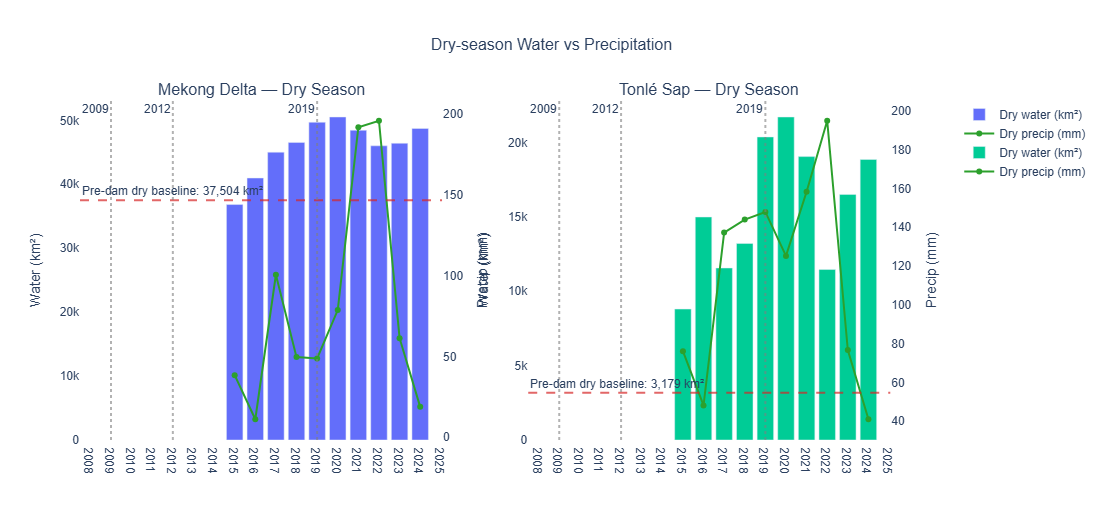

In [205]:
# === Cell 9: Figure 3 - Dry Season Analysis (Dual Axis) ===
def fig_dry_dual_axis(df_delta, df_ts, baselines, events):
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Mekong Delta — Dry Season", "Tonlé Sap — Dry Season"),
                        specs=[[{"secondary_y": True},{"secondary_y": True}]], horizontal_spacing=0.10,
                        )
    fig.update_layout(height=520, width=1200, hovermode="x unified",
                      font=dict(family="Arial, sans-serif", size=12), plot_bgcolor="white", paper_bgcolor="white")

    # Delta
    if {"year","dry_vh_km2","precip_dry_mm"}.issubset(df_delta.columns) and len(df_delta):
        fig.add_trace(go.Bar(x=df_delta["year"], y=df_delta["dry_vh_km2"], name="Dry water (km²)"),
                      row=1, col=1, secondary_y=False)
        fig.add_trace(go.Scatter(x=df_delta["year"], y=df_delta["precip_dry_mm"], mode="lines+markers",
                                 name="Dry precip (mm)", line=dict(color=COLORS["precip"])),
                      row=1, col=1, secondary_y=True)
        add_baseline(fig, baselines["Mekong_Delta"]["dry_km2"], "Pre-dam dry baseline", row=1, col=1)
        add_event_markers(fig, events, row=1, col=1)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=1)

    # Tonlé
    if {"year","dry_vh_km2","precip_dry_mm"}.issubset(df_ts.columns) and len(df_ts):
        fig.add_trace(go.Bar(x=df_ts["year"], y=df_ts["dry_vh_km2"], name="Dry water (km²)"),
                      row=1, col=2, secondary_y=False)
        fig.add_trace(go.Scatter(x=df_ts["year"], y=df_ts["precip_dry_mm"], mode="lines+markers",
                                 name="Dry precip (mm)", line=dict(color=COLORS["precip"])),
                      row=1, col=2, secondary_y=True)
        add_baseline(fig, baselines["Tonle_Sap"]["dry_km2"], "Pre-dam dry baseline", row=1, col=2)
        add_event_markers(fig, events, row=1, col=2)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=2)

    fig.update_yaxes(title_text="Water (km²)", secondary_y=False, row=1, col=1)
    fig.update_yaxes(title_text="Precip (mm)",  secondary_y=True,  row=1, col=1)
    fig.update_yaxes(title_text="Water (km²)", secondary_y=False, row=1, col=2)
    fig.update_yaxes(title_text="Precip (mm)",  secondary_y=True,  row=1, col=2)
    fig.update_xaxes(dtick=1)

    return finalize_figure(fig, "Dry-season Water vs Precipitation", ASSETS / "fig_dry_biaxis.json")

fig3 = fig_dry_dual_axis(df_delta, df_ts, BASE, EVENTS)
fig3.show()


In [206]:
# === Cell 10: Figure 4 - VH Gain Analysis ===
def fig_vh_gain(df_delta, df_ts):
    fig = create_dual_subplot("Mekong Delta — VH minus VV", "Tonlé Sap — VH minus VV", height=480, width=1200)
    if "vh_gain_km2" in df_delta.columns and len(df_delta):
        fig.add_trace(go.Bar(x=df_delta["year"], y=df_delta["vh_gain_km2"], name="Delta VH gain",
                             marker_color=COLORS["gain"]), row=1, col=1)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=1)
    if "vh_gain_km2" in df_ts.columns and len(df_ts):
        fig.add_trace(go.Bar(x=df_ts["year"], y=df_ts["vh_gain_km2"], name="Tonlé VH gain",
                             marker_color=COLORS["gain"]), row=1, col=2)
    else:
        fig.add_annotation(text="No data", xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False, row=1, col=2)
    fig.update_yaxes(title_text="VH-only additional area (km²)", row=1, col=1)
    fig.update_yaxes(title_text="VH-only additional area (km²)", row=1, col=2)
    return finalize_figure(fig, "Additional Inundation Detected by VH (vs VV)", ASSETS / "fig_vh_gain.json")

fig4 = fig_vh_gain(df_delta, df_ts)
fig4.show()


💾 Saved JSON -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\fig_vh_gain.json


In [207]:
# === Cell 11: Manifest 생성 (Dashboard용) ===
manifest = {
    "project": "Mekong SAR Flood Insight",
    "version": "1.0.0",
    "generated_utc": pd.Timestamp.utcnow().isoformat(),
    "events": {k:str(v.date()) for k,v in EVENTS.items()},
    "baselines": BASE,
    "figures": {
        "annual_flood":     "fig_annual_flood.json",
        "flood_vs_precip":  "fig_flood_vs_precip.json",
        "dry_biaxis":       "fig_dry_biaxis.json",
        "vh_gain":          "fig_vh_gain.json",
    }
}
(ASSETS / "manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
print("💾 Saved ->", ASSETS / "manifest.json")


💾 Saved -> C:\Users\wakhan\Desktop\Project\2025\Mekong\notebooks\outputs\web_assets\manifest.json


In [208]:
# === Cell 12: Streamlit App 생성 ===
app_code = r"""
import json
from pathlib import Path
import plotly.graph_objects as go
import streamlit as st

ASSETS = Path("outputs/web_assets")

st.set_page_config(page_title="Mekong SAR Flood Insight", layout="wide")
st.title("Mekong SAR Flood Insight — Interactive Dashboard")

# Manifest
mf = json.loads((ASSETS / "manifest.json").read_text(encoding="utf-8"))
st.caption(f"Generated (UTC): {mf['generated_utc']}")

# Row 1
st.subheader("Annual Flood Extent (VV vs VH)")
fig1_json = json.loads((ASSETS / mf["figures"]["annual_flood"]).read_text(encoding="utf-8"))
st.plotly_chart(go.Figure(fig1_json), use_container_width=True)

# Row 2
col1, col2 = st.columns(2)
with col1:
    st.subheader("Flood vs Precipitation (Aug–Sep)")
    fig2_json = json.loads((ASSETS / mf["figures"]["flood_vs_precip"]).read_text(encoding="utf-8"))
    st.plotly_chart(go.Figure(fig2_json), use_container_width=True)
with col2:
    st.subheader("Dry-season Water vs Precipitation")
    fig3_json = json.loads((ASSETS / mf["figures"]["dry_biaxis"]).read_text(encoding="utf-8"))
    st.plotly_chart(go.Figure(fig3_json), use_container_width=True)

# Row 3
st.subheader("Additional Inundation Detected by VH (vs VV)")
try:
    fig4_json = json.loads((ASSETS / mf["figures"]["vh_gain"]).read_text(encoding="utf-8"))
    st.plotly_chart(go.Figure(fig4_json), use_container_width=True)
except Exception:
    st.info("VH gain figure not available.")

st.divider()
st.markdown("**Data**: COPERNICUS/S1_GRD, CHIRPS, Landsat5 C2.  "
            "**Method**: SAR thresholding + dual-polarization comparison + Landsat baselines.")
"""
(NB_DIR / "app_streamlit.py").write_text(app_code, encoding="utf-8")
print("💾 Saved -> app_streamlit.py")
print("\nRun locally:\n  streamlit run app_streamlit.py")


💾 Saved -> app_streamlit.py

Run locally:
  streamlit run app_streamlit.py
